# San Francisco Crime Classification

San Franscisco Crime Classification is predictive analytics problem of predicting the criminal occurances in the city of San Francisco. San Franscisco released publically released their dataset on Kaggle and People have worked on this data to predict the category of crime based on the below feature<br><br>
<font size="4"><b>**Target:**</b></font>
<br>
<font size="3">
<br>
    <ol><li> <b>Category</b>: The Type of the crime</li></ol>
</font>
<br>
<font size="4"><b>Features:</b></font>
<br><br>
<font size="3">
     <ol><li> Dates:  Timestamp of the crime incident</li>
     <li> Descript: Detail Description of the crime incident</li>
     <li> DayOfWeek: The day of the Week</li>
     <li> pdDistrict: Name of the Polic Department District</li>
     <li> <sup>**</sup>Resolution: How the incident was resolved</li>
     <li> Address: Approximate Streep address of the crime incident</li>
     <li> X: Longitude of the location</li>
     <li> Y: Lattitude of the location</li></ol>
</font>

** <font size="2">This column is causing a data leakage as it liking an information from the future as it will not be available when the incident happends, so we will discraad this feature</font>

References:
    <ol><li><a href="https://www.kaggle.com/c/sf-crime/data">https://www.kaggle.com/c/sf-crime/data</a></li>
    <li><a href="https://arxiv.org/pdf/1607.03626.pdf">https://arxiv.org/pdf/1607.03626.pdf</a></li></ol>

## Import the libraries

In [13]:
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score, roc_curve, auc,confusion_matrix
from sklearn import metrics

from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline

## Data Explaoration and preprocessing

We will laod the data and try to visualize some information. In addition we will also transform the data to the desired format by using some transfomations which might be helpful in visualization and classification

**Read the dataset and diplay few rows**

In [14]:
train=pd.read_csv("data/train.csv");
test=pd.read_csv("data/test.csv");
train['Dates']=pd.to_datetime(train['Dates'])
test['Dates']=pd.to_datetime(test['Dates'])

output_class_labels=train['Category'].unique()
print("Total Training data:",train.shape[0])
print("Total features:",train.shape[1])
train.head()

Total Training data: 878049
Total features: 9


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


**Check if the data contains any missing values**

In [15]:
train.apply(lambda x: sum(x.isnull()),axis=0)

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

The dataset does not contain any missing values, hence no imputation is required

#### Visualize the crime locations through scatter plot

<Figure size 2160x2160 with 0 Axes>

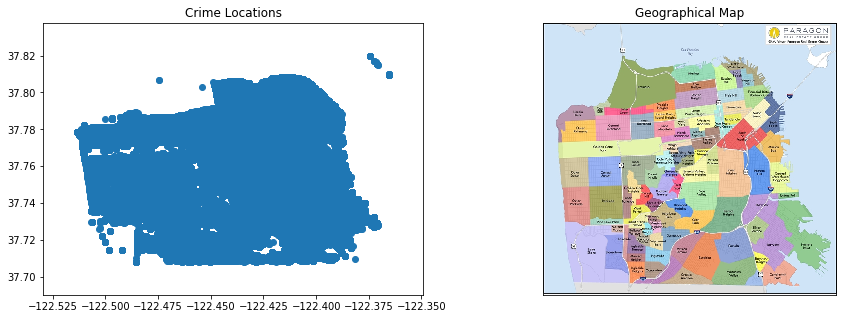

In [16]:
plt.figure(figsize=(30,30))
# longitudes vs latitudes
longitudes=train['X']
latitudes=train['Y']


subset=500000
latitudes=latitudes[0:subset]
longitudes=longitudes[0:subset]
plt.figure(figsize=(15,5))
axis_label_font = {'size':'20', 'color':'#165880'}
axis_tic_font = {'size':'20', 'color':'#165880'}

plt.xlabel("Latituede",axis_label_font)
plt.ylabel("Longatitue",axis_tic_font)


plt.xticks(np.arange(-122.4, -122.6))
plt.yticks(np.arange(37.46, 37.85))

plt.subplot(1,2,1)
plt.scatter(longitudes, latitudes)
plt.title("Crime Locations")
plt.subplot(1,2,2)
sf=plt.imread('sanfr.jpg')
plt.xticks([])
plt.yticks([])
plt.imshow(sf)
plt.title("Geographical Map")
plt.show()

**Transformations:**

It makes more sense to break the time stamp in day, month, year, hour, miniute and seconds and utilize the date, month and hour as the feature instead of the tiem stamp. In addition we will drop the timestamp column and also drop thr resolution column as discussed earlier and Descript column

In [17]:
train['Date']=train.iloc[:,0].apply(lambda x: x.day)
train['Month']=train.iloc[:,0].apply(lambda x: x.month)
train['Hour']=train.iloc[:,0].apply(lambda x: x.hour)
train.drop('Dates', axis=1, inplace=True)
train.drop('Resolution', axis=1, inplace=True)
train.drop('Descript', axis=1, inplace=True)

As suggested by the Abouelnaga, 2016[1] Most of teh Address variables could be usesful by checking if it contains the Keyword "BLOCK". SO lets create a feature Block_Ind which represents whether an addresss contains BLOCK word. In addition we will extract the Stree number form the address if present else will put as 0.

In [18]:
train['Block_Ind']=train['Address'].apply(lambda x: 1 if 'block' in x.lower() else 0)
train['Street'] = train['Address'].apply(lambda x: x.split(" ")[0] if x.split(" ")[0].isnumeric() else 0)
train.drop('Address', axis=1, inplace=True)

### Normalization

We are going to normalize the lattitude and logitude

In [19]:
min_X = train['X'].min()
#std_X = train['X'].std()
min_Y = train['Y'].min()
#std_Y = train['Y'].std()
train['X'] = (train['X'] - min_X)
train['Y'] = (train['Y'] - min_Y)

### Crime data based on Day of the Week, Date, Month and Hour of the Day

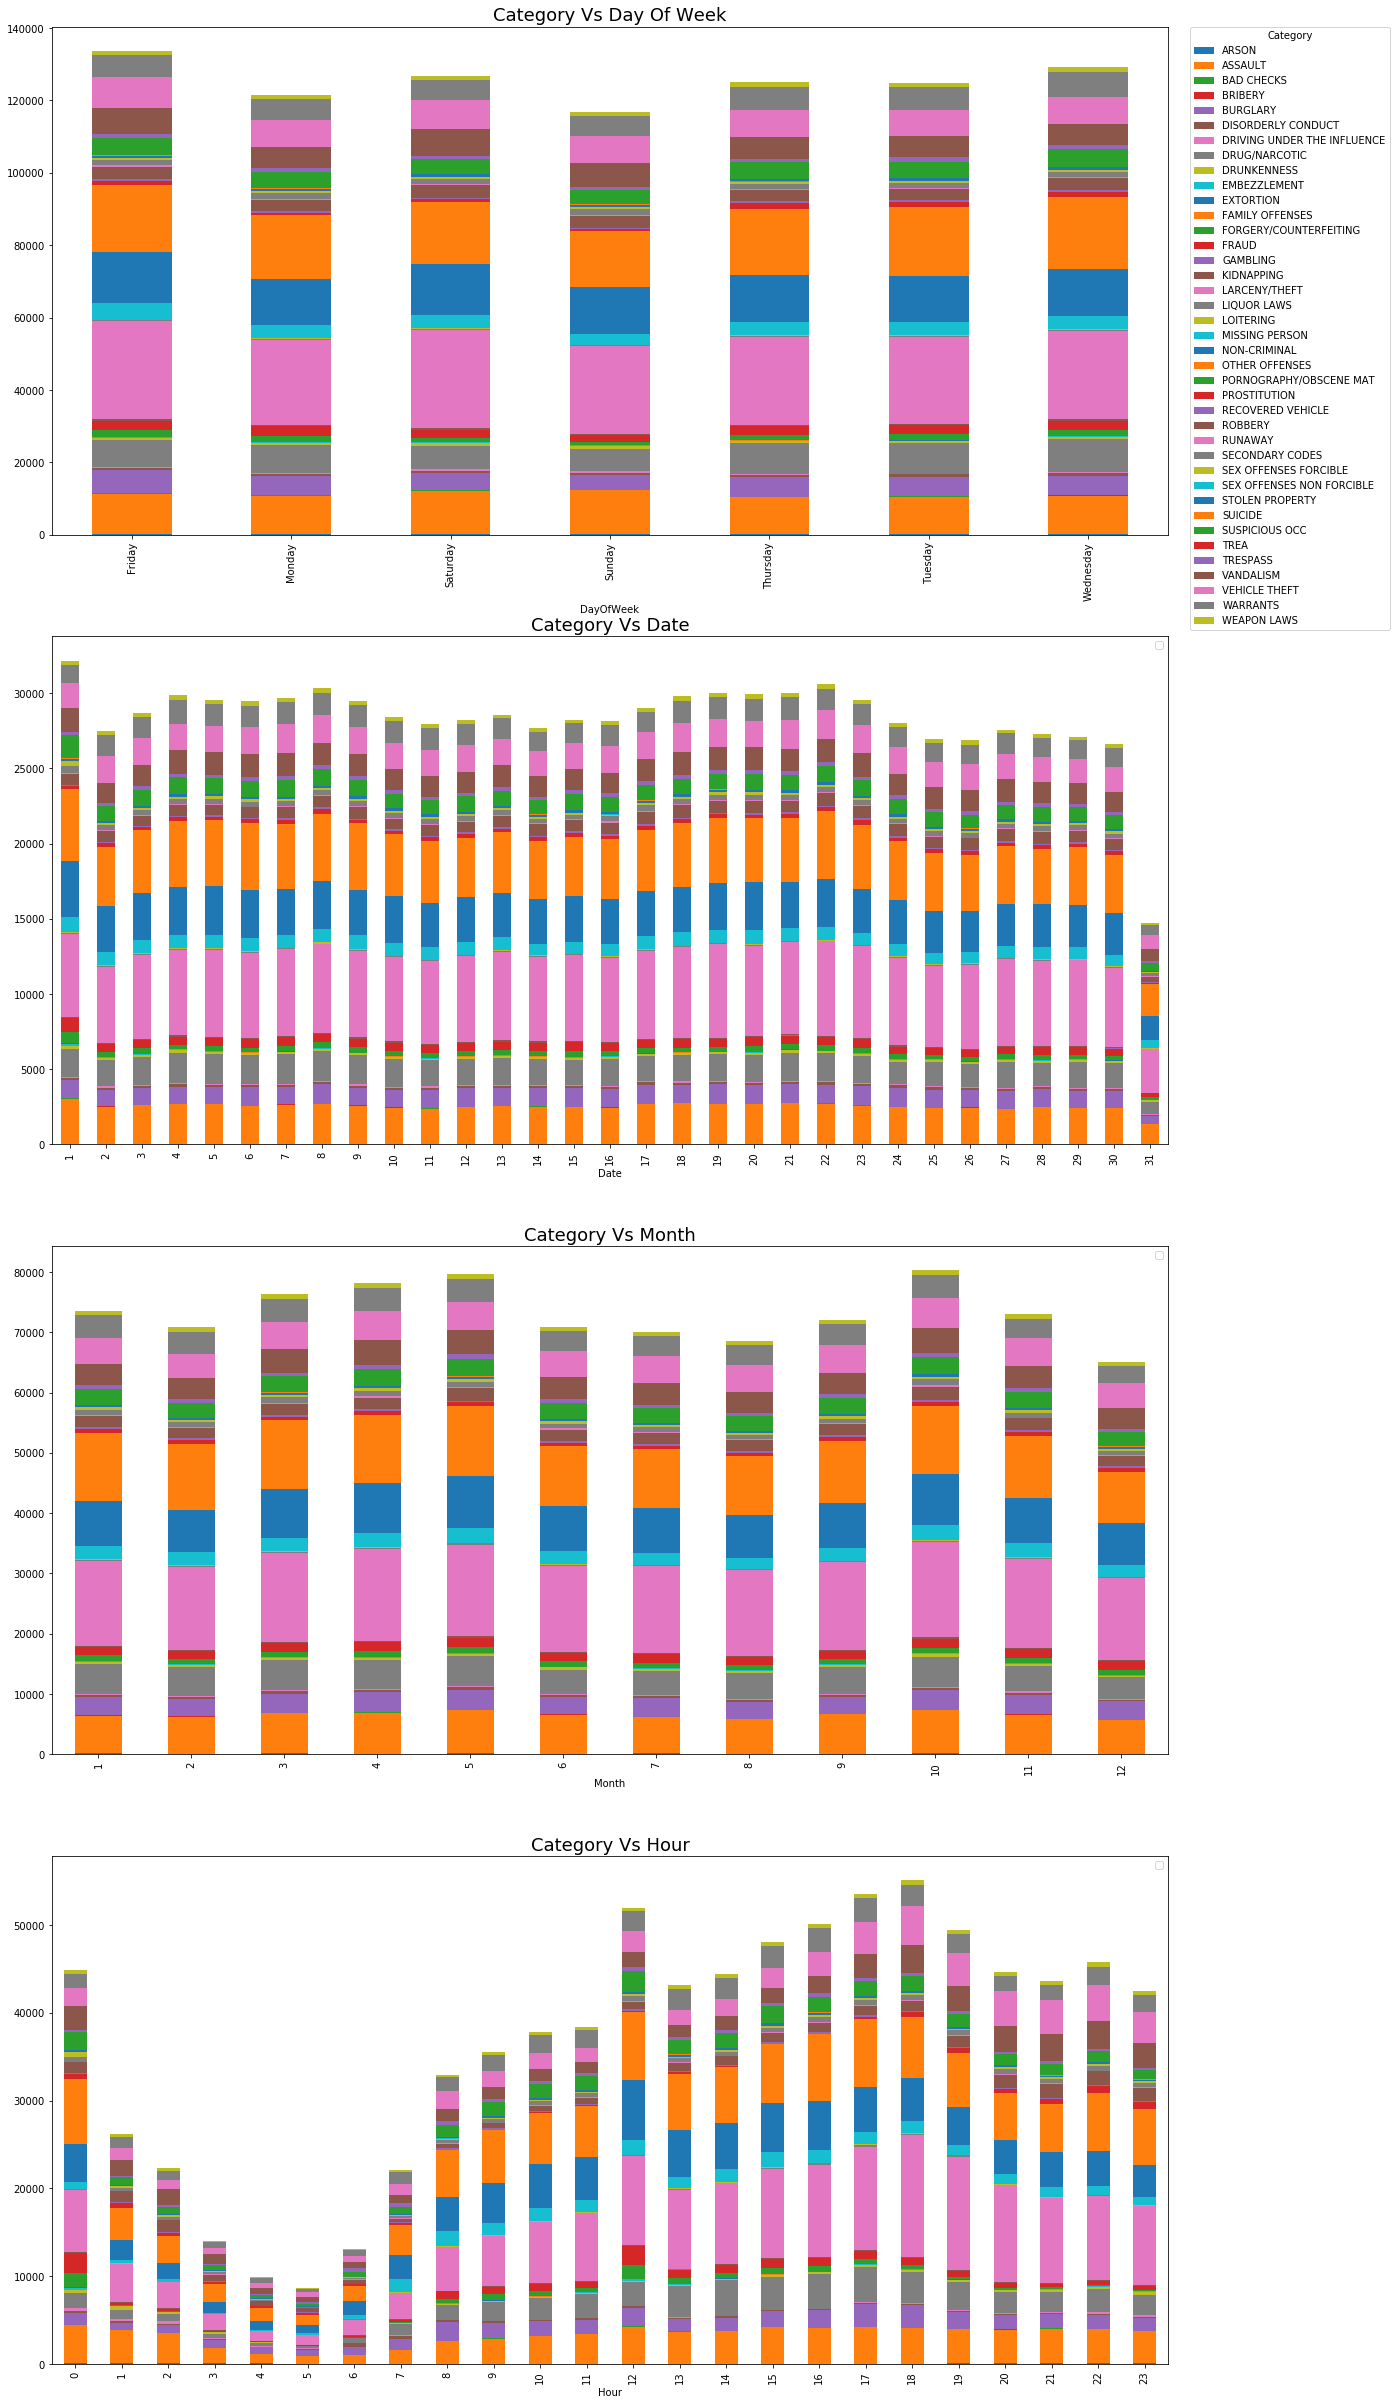

In [20]:
fig, ax= plt.subplots(nrows=4, ncols=1)
fig.set_size_inches(20, 43)
tmp=pd.crosstab(train.DayOfWeek, train.Category).plot.bar(stacked=True, ax=ax[0])
ax[0].legend(title='Category', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax[0].set_title("Category Vs Day Of Week", size=18)

tmp=pd.crosstab(train.Date, train.Category).plot.bar(stacked=True, ax=ax[1])
ax[1].legend([])
ax[1].set_title("Category Vs Date", size=18)

tmp=pd.crosstab(train.Month, train.Category).plot.bar(stacked=True, ax=ax[2])
ax[2].legend([])
ax[2].set_title("Category Vs Month", size=18)

tmp=pd.crosstab(train.Hour, train.Category).plot.bar(stacked=True, ax=ax[3])
ax[3].legend([])
ax[3].set_title("Category Vs Hour", size=18)
plt.show()

### Crime data based on District and Street Numbers

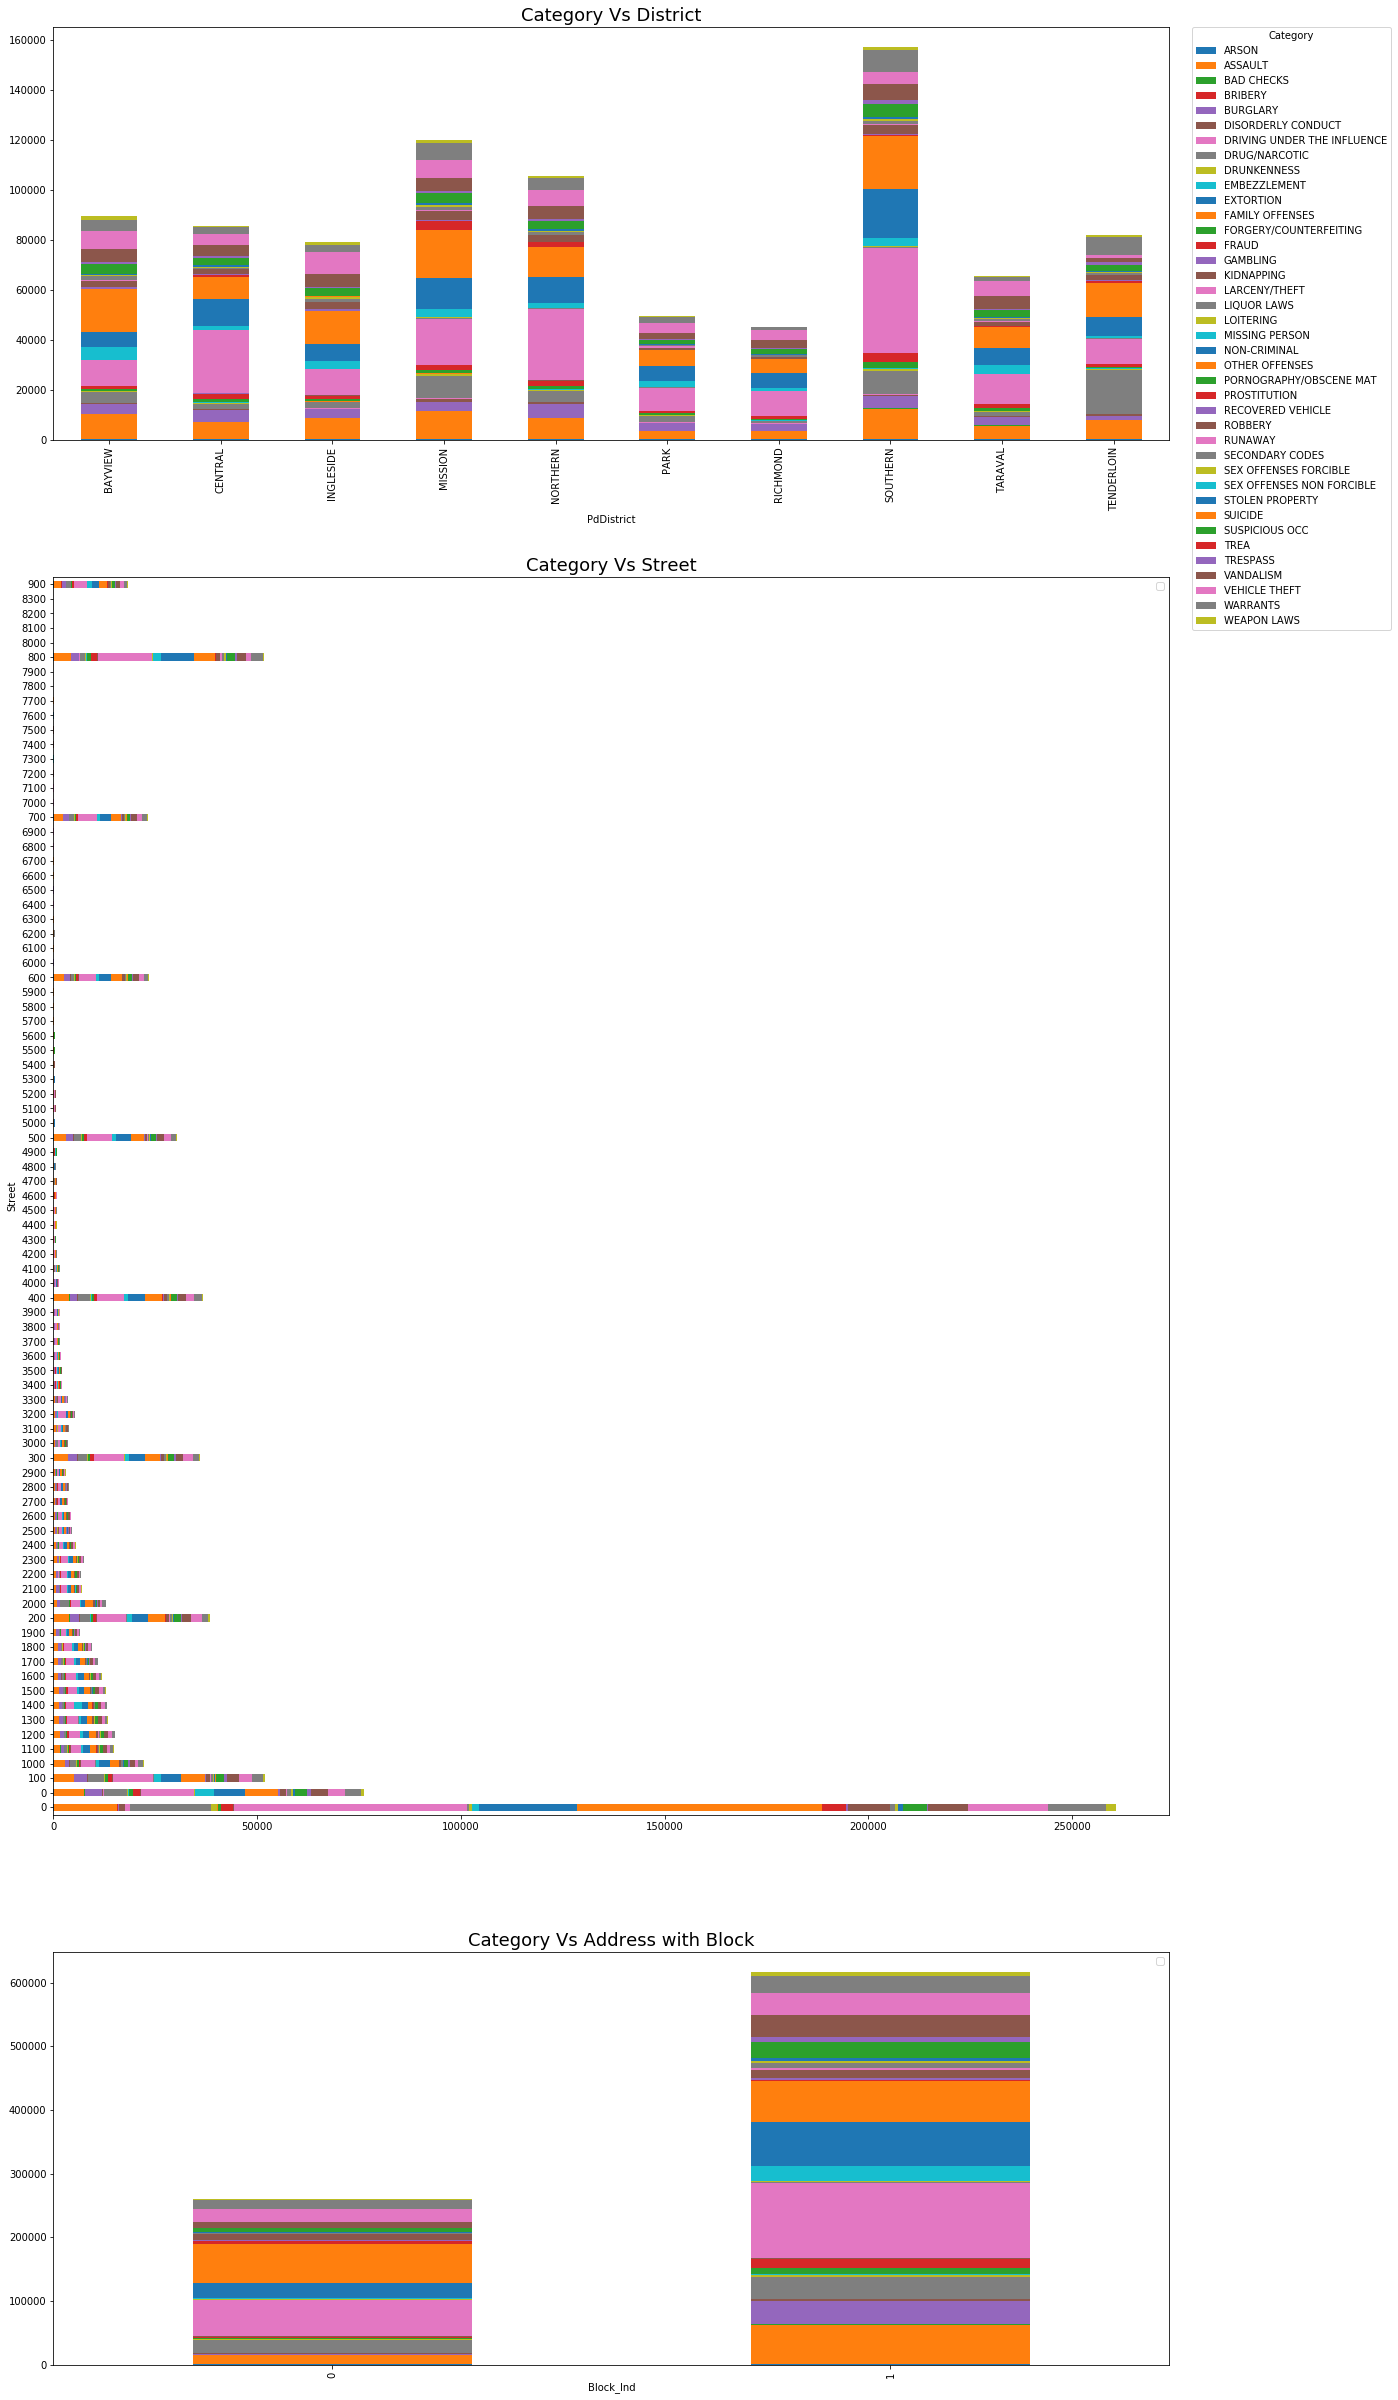

In [21]:
fig, ax= plt.subplots(nrows=3, ncols=1, gridspec_kw = {'height_ratios':[1, 3, 1]})
fig.set_size_inches(20, 43)
tmp=pd.crosstab(train.PdDistrict, train.Category).plot.bar(stacked=True, ax=ax[0])
ax[0].legend(title='Category', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax[0].set_title("Category Vs District", size=18)
tmp=pd.crosstab(train.Street, train.Category).plot.barh(stacked=True, ax=ax[1])
ax[1].legend([])
ax[1].set_title("Category Vs Street", size=18)

tmp=pd.crosstab(train.Block_Ind, train.Category).plot.bar(stacked=True, ax=ax[2])
ax[2].legend([])
ax[2].set_title("Category Vs Address with Block", size=18)
plt.show()

#### Feature Transformation
We are going to transform the few of the features values to the numerical labels so that our learning model can work on it. In addition we will derive 3 features from the date features that is hour of the day, day of the month and month of the year to and will use as feature instead of a single data.

We will drop the column Description, Resolution and Adress since we are wont have the Description and Resolution of the event and Address can be discarded considering we have lattitudes and longitudes

In [22]:
def transform_feature(dataframe):
    hour=dataframe['Hour']
    date= dataframe['Date']
    month=dataframe['Month']
    longitude=dataframe["X"]
    lattitude=dataframe["Y"]
    block= dataframe['Block_Ind']
    street=dataframe['Month']
    
    #Get binary vector for these varaibles and create columns
    weekday = pd.get_dummies(dataframe['DayOfWeek'])
    district = pd.get_dummies(dataframe['PdDistrict'])
    return pd.concat([hour, date, month, weekday, district, block, street, lattitude, longitude], axis=1)
    
encoder = preprocessing.LabelEncoder()
category=train['Category']
train_transformed=transform_feature(train)
train_transformed['Category'] = encoder.fit_transform(category)

#### Data split

We will split the dataset in the ratio of 80% and 20% so that once we build our model we can check how its performing

In [23]:
train_data=train_transformed.sample(frac=0.8,random_state=200)
validation_data=train_transformed.drop(train_data.index)

train_features=train_data.iloc[:,0:train_transformed.shape[1]-1]
train_labels=train_data.iloc[:,train_transformed.shape[1]-1]
validation_features=validation_data.iloc[:,0:train_transformed.shape[1]-1]
validation_labels=validation_data.iloc[:,train_transformed.shape[1]-1]

print(train_features.shape)
print(validation_features.shape)

(702439, 24)
(175610, 24)


#### Helper Functions

In [24]:
def get_next_batch(data, labels, batch_size, batch_number):
    # This method is used to feed the batch of images to train the model
    start_index = batch_number*batch_size
    end_index = batch_size*(batch_number+1)
    return np.array(data[start_index:end_index]), np.array(labels[start_index:end_index])

def dummy_encoding(labels):
    # This function is use to teh binary encoding of teh labels
    n_class = np.unique(labels).shape[0]
    with tf.Session() as sess:
        labels = sess.run(tf.one_hot(labels, n_class))
    return labels

## Model Building

#### Build a Logistic Regression Classifier

In [13]:
start_time=time.clock()
logistic_model=LogisticRegression()#penalty='l2', tol=0)
model_data_file="logistic_classifer_model.dat"
logistic_model.fit(train_features,train_labels)
predicted_prob=logistic_model.predict_proba(train_features)
#print("Log loss for = %s " % "{0:.8}".format(log_loss(labels_train, predicted_prob)))
print("\nLogistic Classifier Took "+str(round(time.clock()-start_time,2))+" seconds")


Logistic Classifier Took 566.42 seconds


#### Accuracy on Training Data

In [14]:
logistic_train_pred=logistic_model.predict(train_features)
logistic_accuracy=metrics.accuracy_score(logistic_train_pred,train_labels)
print("Accuracy (Logistic Classifer) on training dataset= %s " % "{0:.5}%".format(logistic_accuracy*100))

Accuracy (Logistic Classifer) on training dataset= 22.769% 


#### Accuracy on Validation Data

In [15]:
logistic_val_pred=logistic_model.predict(validation_features)
logistic_accuracy=metrics.accuracy_score(logistic_val_pred,validation_labels)
print("Accuracy (Logistic Classifer) on validation dataset= %s " % "{0:.5}%".format(logistic_accuracy*100))

Accuracy (Logistic Classifer) on validation dataset= 22.789% 


#### Build a Neural Network Classifier (Using Tensorflow)

In [25]:
#train_features = np.array(training.drop('Category', axis=1))
#validation_features = np.array(validation.drop('Category', axis=1))
train_labels_nn= np.int32(dummy_encoding(np.array(train_labels)))
validation_labels_nn = np.int32(dummy_encoding(np.array(validation_labels)))

In [30]:
input_size = train_features.shape[1]
output_size = train_labels_nn.shape[1]
h1_nodes = 64
h2_nodes = 1024
h3_nodes = 128
nodes = [input_size, h1_nodes, output_size]
alpha=0.1

#Create the place holder
X = tf.placeholder(tf.float32, [None, input_size])
Y = tf.placeholder(tf.float32, [None, output_size])
keep_prob = tf.placeholder("float")

weights={}
bias ={}

# create the graph
previous_layer_ouput = X
l2_loss=tf.constant(0.0)
for i in range(1, len(nodes)):
    weights['layer'+str(i)] = tf.Variable(tf.truncated_normal([nodes[i-1], nodes[i]], stddev=0.03), name="W"+str(i))
    bias['layer'+str(i)] = tf.Variable(tf.constant(0.05, shape=[nodes[i]]), name="b"+str(i))
    l2_loss=tf.add(l2_loss, tf.nn.l2_loss(weights['layer'+str(i)]))
    if i ==len(nodes)-1:
        y_out = tf.add(tf.matmul(previous_layer_ouput, weights['layer'+str(i)]), bias['layer'+str(i)])
    previous_layer_ouput = tf.add(tf.matmul(previous_layer_ouput, weights['layer'+str(i)]), bias['layer'+str(i)])
    previous_layer_ouput = tf.nn.dropout(previous_layer_ouput, keep_prob)
    
#y_out = tf.clip_by_value(y_out, 1e-10, 0.9999999)
#cross_entropy = -tf.reduce_mean(tf.reduce_sum(Y*tf.log(y_out)+(1-Y)*tf.log(1-y_out), axis=1))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_out, labels=Y))
l2_constant = 0
optimizer = tf.train.AdamOptimizer().minimize(cross_entropy + l2_constant*l2_loss)
init_op = tf.global_variables_initializer()
correct_classification = tf.equal(tf.argmax(Y, 1), tf.argmax(y_out, 1))
accuracy = tf.reduce_mean(tf.cast(correct_classification, tf.float32))

#### Run the Tensorflow Session

In [31]:
start_time=time.clock()
hm_epoch = 20
batch_size=256
with tf.Session() as sess:
    sess.run(init_op)
    for epoch in range(hm_epoch):
        epoch_cost = 0
        n_batch = int(train_features.shape[0] / batch_size)
        for batch in range(n_batch):
            batch_x, batch_y = get_next_batch(train_features, train_labels_nn, batch_size, batch)
            _, cost = sess.run([optimizer, cross_entropy], feed_dict={X:batch_x, Y:batch_y, keep_prob : 0.8})
            epoch_cost += cost
        
        if epoch%5 == 0:
            print ("Cost in epoch ", epoch, " = ", "{:.3f}".format(epoch_cost/n_batch))
            
    #print("Training Accuracy=", np.round(100*sess.run(accuracy,feed_dict={X:train_features, Y:train_labels_nn, keep_prob : 1}), 2), "%")
    print("Validation Accuracy=", np.round(100*sess.run(accuracy,feed_dict={X:validation_features, Y:validation_labels_nn, keep_prob : 1}), 2),"%")
    
print("Deep Neural Network Took "+str(round(time.clock()-start_time,2))+" seconds")

Cost in epoch  0  =  2.604
Cost in epoch  5  =  2.568
Cost in epoch  10  =  2.567
Cost in epoch  15  =  2.566
Validation Accuracy= 22.8 %
Deep Neural Network Took 114.46 seconds
